## Driver Activity Recognition

In [34]:
import os
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

In [35]:
kaggleDir = '/kaggle/input/state-farm-distracted-driver-detection/'
train_img_dir = 'train/'
test_img_dir = 'test/'

In [36]:
df_train = pd.read_csv(kaggleDir + 'driver_imgs_list.csv', low_memory=True)
print('Number of Samples in trainset : {}'.format(df_train.shape[0]))
print('Number Of districted Classes : {}'.format(len((df_train.classname).unique())))

Number of Samples in trainset : 22424
Number Of districted Classes : 10


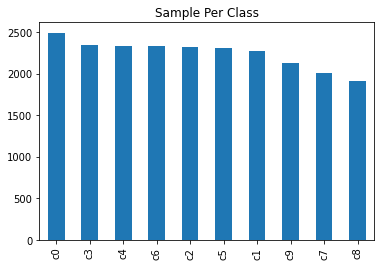

In [37]:
class_freq_count = df_train.classname.value_counts()

class_freq_count.plot(kind='bar', label='index')
plt.title('Sample Per Class');
plt.show()

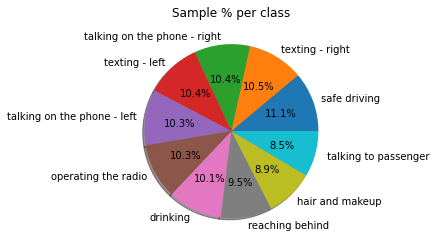

In [38]:
CLASSES = {"c0": "safe driving", "c1": "texting - right", "c2": "talking on the phone - right", "c3": "texting - left",
           "c4": "talking on the phone - left", "c5": "operating the radio", "c6": "drinking", "c7": "reaching behind",
           "c8": "hair and makeup", "c9": " talking to passenger"}
plt.pie(class_freq_count, autopct='%1.1f%%', shadow=True, labels=CLASSES.values())
plt.title('Sample % per class');
plt.show()

In [39]:
dataset = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


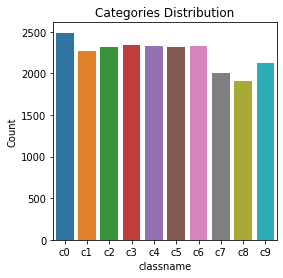

In [40]:
# Plot figure size
plt.figure(figsize = (4,4))
# Count the number of images per category
sns.countplot(x = 'classname', data = dataset)
# Change the Axis names
plt.ylabel('Count')
plt.title('Categories Distribution')
# Show plot
plt.show()

<Figure size 720x720 with 0 Axes>

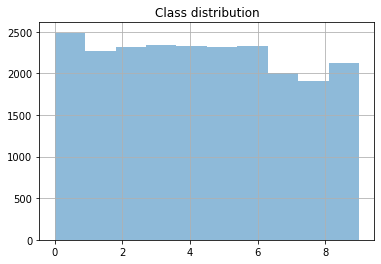

In [41]:
dataset['class_type'] = dataset['classname'].str.extract('(\d)',expand=False).astype(np.float)
plt.figure(figsize = (10,10))
dataset.hist('class_type', alpha=0.5, layout=(1,1), bins=10)
plt.title('Class distribution')
plt.show()

uint8
(480, 640, 3)


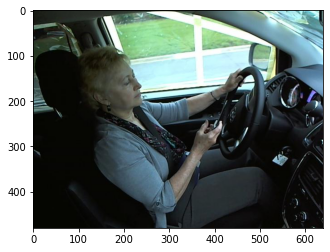

In [42]:
from matplotlib import image
from matplotlib import pyplot

#load image as pixel array
data=image.imread(r"../input/state-farm-distracted-driver-detection/imgs/train/c1/img_448.jpg")
#summarize shape of the pixel array
print(data.dtype)
print(data.shape)
#display the arrays of pixels as an image
pyplot.imshow(data)
pyplot.show()

uint8
(240, 240)


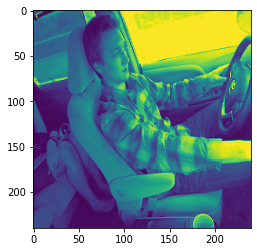

In [43]:
from matplotlib import image
from matplotlib import pyplot

#load image as pixel array
data=cv2.imread(r"../input/state-farm-distracted-driver-detection/imgs/train/c5/img_100027.jpg",cv2.IMREAD_GRAYSCALE)
#summarize shape of the pixel array
data=cv2.resize(data,(240,240))
print(data.dtype)
print(data.shape)
#display the arrays of pixels as an image
pyplot.imshow(data)
pyplot.show()

In [44]:
files=os.listdir(r"../input/state-farm-distracted-driver-detection/imgs/train")
print("Number of files in train:",len(files))

Number of files in train: 10


In [45]:
files=os.listdir(r"../input/state-farm-distracted-driver-detection/imgs/train")
print("Number of files in train:",len(files))

Number of files in train: 10


In [46]:
c1=os.listdir(r"../input/state-farm-distracted-driver-detection/imgs/train/c1")
print("Number of images in C1 class:",len(c1))

Number of images in C1 class: 2267


In [47]:
test_im=os.listdir(r"../input/state-farm-distracted-driver-detection/imgs/test")
print("Number of images in Test:",len(test_im))

Number of images in Test: 79726


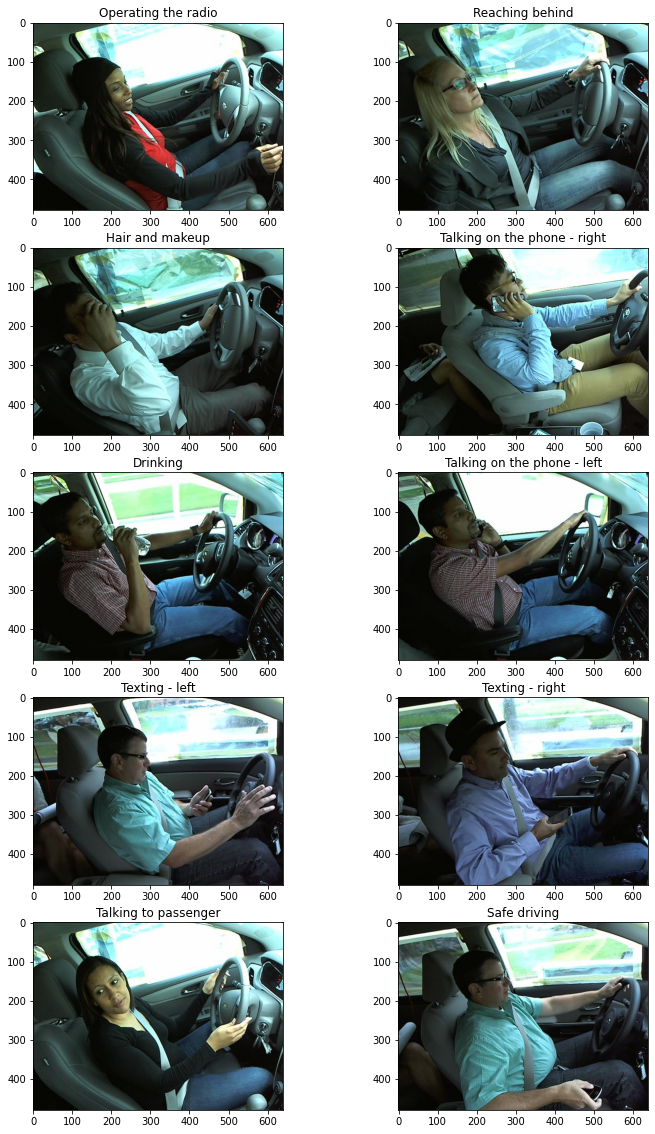

In [48]:
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}


plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = r'../input/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [49]:
train_directory = r"../input/state-farm-distracted-driver-detection/imgs/train"
test_directory =r"../input/state-farm-distracted-driver-detection/imgs/test"
classes = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

In [50]:
img_size1 = 240
img_size2 = 240

In [51]:
import os
import cv2
#TRAINING DATA

training_data = []
i = 0
def create_training_data():
    for category in classes:
        path = os.path.join(train_directory,category)
        class_num = classes.index(category)
        
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            new_img = cv2.resize(img_array,(img_size2,img_size1))
            training_data.append([new_img,class_num])

In [52]:
testing_data = []
i = 0
def create_testing_data():        
    for img in os.listdir(test_directory):
        img_array = cv2.imread(os.path.join(test_directory,img),cv2.IMREAD_GRAYSCALE)
        new_img = cv2.resize(img_array,(img_size2,img_size1))
        testing_data.append([img,new_img])

In [53]:
create_training_data()

In [54]:
create_testing_data()

In [55]:
import random
random.shuffle(training_data)

In [56]:
x = []
y = []
for features, label in training_data:
    x.append(features)
    y.append(label)

In [57]:
import numpy as np
X = np.array(x).reshape(-1,img_size2,img_size1,1)
X[0].shape

(240, 240, 1)

In [58]:
y=np.array(y).reshape(-1,1)

In [59]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=50)

In [60]:
from keras.utils import np_utils
Y_train = np_utils.to_categorical(y_train,num_classes=10)
Y_test = np_utils.to_categorical(y_test,num_classes=10)

In [61]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
model = keras.models.Sequential()

In [62]:
from keras.callbacks import ModelCheckpoint
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [63]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(240,240,1)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [64]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 240, 240, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 120, 120, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 60, 60, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 60, 60, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 512)      

In [65]:
history_v1 = model_v1.fit(x_train, Y_train, epochs=10,batch_size=40,validation_data=(x_test , Y_test))

Epoch 1/10
449/449 [==============================] - 547s 1s/step - loss: 250.3028 - accuracy: 0.4582 - val_loss: 0.1882 - val_accuracy: 0.9483
Epoch 2/10
449/449 [==============================] - 535s 1s/step - loss: 0.1660 - accuracy: 0.9622 - val_loss: 0.1059 - val_accuracy: 0.9755
Epoch 3/10
449/449 [==============================] - 535s 1s/step - loss: 0.0569 - accuracy: 0.9845 - val_loss: 0.2211 - val_accuracy: 0.9726
Epoch 4/10
449/449 [==============================] - 535s 1s/step - loss: 0.0483 - accuracy: 0.9920 - val_loss: 0.0826 - val_accuracy: 0.9790
Epoch 5/10
449/449 [==============================] - 535s 1s/step - loss: 0.0456 - accuracy: 0.9916 - val_loss: 0.0949 - val_accuracy: 0.9893
Epoch 6/10
449/449 [==============================] - 535s 1s/step - loss: 0.0414 - accuracy: 0.9948 - val_loss: 0.1201 - val_accuracy: 0.9868
Epoch 7/10
449/449 [==============================] - 535s 1s/step - loss: 0.0600 - accuracy: 0.9941 - val_loss: 0.0927 - val_accuracy: 0.99

In [66]:
import matplotlib.pyplot as plt
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

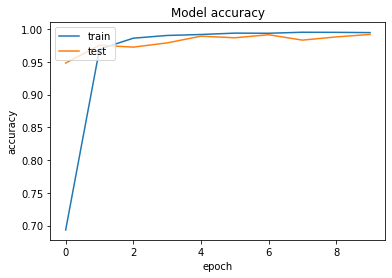

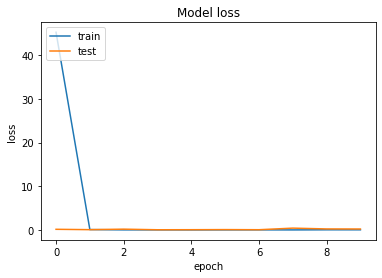

In [67]:
plot_train_history(history_v1)

In [68]:
score = model_v1.evaluate(x_test, Y_test, verbose=1)
print('Score of V1 model: ', score)

141/141 [==============================] - 106s 717ms/step - loss: 0.2576 - accuracy: 0.9918
Score of V1 model:  [0.257583886384964, 0.9917502999305725]


In [69]:
preds = model_v1.predict(np.array(testing_data[100][1]).reshape(-1,img_size2,img_size1,1))
test_data = np.array(testing_data[100][1]).reshape(-1,img_size2,img_size1,1)

preds = model_v1.predict(test_data)
preds

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.9528889e-11, 2.8184446e-32, 1.0000000e+00, 5.7930513e-25,
        4.2642359e-32, 0.0000000e+00]], dtype=float32)

Predicted: 6


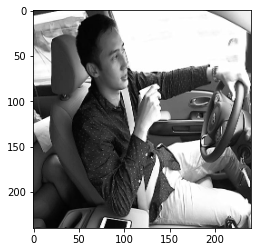

In [70]:
import matplotlib.pyplot as plt

print('Predicted: {}'.format(np.argmax(preds)))

new_img = cv2.resize(testing_data[100][1],(img_size2,img_size1))
plt.imshow(new_img,cmap='gray')
plt.show()

In [71]:
preds = model_v1.predict(np.array(testing_data[200][1]).reshape(-1,img_size2,img_size1,1))
test_data = np.array(testing_data[200][1]).reshape(-1,img_size2,img_size1,1)

preds = model_v1.predict(test_data)
preds

array([[1.86377979e-11, 3.64634267e-14, 9.99944806e-01, 0.00000000e+00,
        1.48989700e-29, 8.89156763e-06, 6.77488556e-13, 1.44912651e-10,
        1.32888995e-11, 4.62279568e-05]], dtype=float32)

## Model_V3

In [72]:
def create_model_v3():
    model = Sequential()
    
    model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = (240, 240, 3), data_format = 'channels_last'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Flatten())
    model.add(Dense(units = 1024, activation = 'relu'))
    
    model.add(Dense(units = 256, activation = 'relu'))
    model.add(Dense(units = 10, activation = 'sigmoid'))


    
    return model

In [73]:
model_v3 = create_model_v3()

# More details about the layers
model_v3.summary()

# Compiling the model
model_v3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 238, 238, 128)     3584      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 119, 119, 128)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 117, 117, 64)      73792     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 58, 58, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 56, 56, 32)        18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 28, 28, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)            

In [74]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

training_set = train_datagen.flow_from_directory('../input/state-farm-distracted-driver-detection/imgs/train', 
                                                 target_size = (240, 240), 
                                                 batch_size = 32,
                                                 subset = 'training')

validation_set = train_datagen.flow_from_directory('../input/state-farm-distracted-driver-detection/imgs/train', 
                                                   target_size = (240, 240), 
                                                   batch_size = 32,
                                                   subset = 'validation')

Found 17943 images belonging to 10 classes.
Found 4481 images belonging to 10 classes.


In [75]:
import os
os.chdir(r'/kaggle/working')

In [ ]:
checkpoint_cb=keras.callbacks.ModelCheckpoint("./cnn_newvanilla.hdf5",save_best_only=True)

history = model_v3.fit_generator(training_set,
                         steps_per_epoch = 17943/32,
                         epochs = 10,
                         validation_data = validation_set,
                         validation_steps = 4481/32,
                         callbacks=[checkpoint_cb])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
560/560 [==============================] - 490s 868ms/step - loss: 1.7276 - accuracy: 0.3727 - val_loss: 0.4491 - val_accuracy: 0.8612
Epoch 2/10
560/560 [==============================] - 457s 815ms/step - loss: 0.3759 - accuracy: 0.8799 - val_loss: 0.2244 - val_accuracy: 0.9288
Epoch 3/10
560/560 [==============================] - 458s 817ms/step - loss: 0.2106 - accuracy: 0.9329 - val_loss: 0.1704 - val_accuracy: 0.9458
Epoch 4/10
560/560 [==============================] - 459s 818ms/step - loss: 0.1441 - accuracy: 0.9536 - val_loss: 0.1511 - val_accuracy: 0.9522
Epoch 5/10
561/560 [==============================] - ETA: 0s - loss: 0.1074 - accuracy: 0.9662

In [ ]:
model_v3.save('./cnn_newvanilla.hdf5')

In [ ]:
modelnew = keras.models.load_model("cnn_newvanilla.hdf5")

In [ ]:
import matplotlib.pyplot as plt
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [ ]:
plot_train_history(history)